## Supervised learning

## Import libraries

In [1]:
from dotenv import load_dotenv
import os

# take environment variables from .env.
load_dotenv()

True

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


warnings.filterwarnings('ignore')

## Retrieve data

In [4]:
# path_to_csv = "/Users/emilyanderson/Desktop/HR_Engagement_Sat_Sales_UpdatedV4.0.csv"
# path_to_csv = os.getenv("DATA_HR")
# data = pd.read_csv(path_to_csv)

data_path = os.getenv("DATA_HR")
data_path = '../' + data_path

#Retrieve dataset from local directory
data = pd.read_csv(data_path)

In [5]:
pd.set_option('display.max_columns', None)
print(data.shape)
data.head()

(14999, 62)


ID      Name       Department     GEO             Role  Rising_Star  \
0   1    BRADDY       Operations      US               VP          NaN   
1   2     BORST            Sales      UK  Senior Director          NaN   
2   3  BIRDWELL          Finance  France  Senior Director          NaN   
3   4      BENT  Human Resources   China  Senior Director          NaN   
4   5     BAZAN               IT   Korea         Director          NaN   

   Will_Relocate  Critical  Trending Perf  Talent_Level  \
0              0       1.0              3             6   
1              0       NaN              3             6   
2              0       NaN              3             6   
3              0       NaN              3             6   
4              0       NaN              3             6   

   Validated_Talent_Level  Percent_Remote  EMP_Sat_OnPrem_1  EMP_Sat_OnPrem_2  \
0                       6             0.4               3.0               3.0   
1                       6             0.4               3.0               3.0   
2                       6             0.4               3.0               3.0   
3                       6             0.4               3.0               3.0   
4                       6             0.4               3.0               3.0   

   EMP_Sat_OnPrem_3  EMP_Sat_OnPrem_4  EMP_Sat_OnPrem_5  EMP_Sat_Remote_1  \
0               4.0               3.0               5.0                 2   
1               4.0               3.0               5.0                 2   
2               4.0               3.0               5.0                 2   
3               4.0               3.0               5.0                 2   
4               4.0               3.0               5.0                 2   

   EMP_Sat_Remote_2  EMP_Sat_Remote_3  EMP_Sat_Remote_4  EMP_Sat_Remote_5  \
0                 3                 2                 3                 2   
1                 3                 2                 3                 2   
2                 3                 2                 3                 2   
3                 3                 2                 3                 2   
4                 3                 2                 3                 2   

   EMP_Engagement_1  EMP_Engagement_2  EMP_Engagement_3  EMP_Engagement_4  \
0                 5                 5                 4                 4   
1                 5                 5                 4                 4   
2                 5                 5                 4                 4   
3                 5                 5                 4                 4   
4                 5                 5                 4                 4   

   EMP_Engagement_5  last_evaluation  number_project  average_montly_hours  \
0                 3             0.36               3                   168   
1                 3             0.36               5                   159   
2                 3             0.36               2                   282   
3                 3             0.36               4                   278   
4                 3             0.36               6                   256   

   time_spend_company  Work_accident  left_Company  CSR Factor  \
0                   3              1             0         NaN   
1                   2              0             0         NaN   
2                   3              0             0         NaN   
3                   4              1             0         NaN   
4                   5              0             0         NaN   

   promotion_last_5years        sales  salary Gender  LinkedIn_Hits  \
0                      0        sales     low      M              5   
1                      0   accounting     low      F             58   
2                      0  product_mng  medium      F             42   
3                      0  product_mng    high      M             37   
4                      0        sales     low      F              6   

   Emp_Work_Status2  Emp_Work_Stat

In [6]:
data.drop(columns = ['ID','Name','Rising_Star', 'Trending Perf', 'Talent_Level',
                     'Validated_Talent_Level', 'EMP_Sat_OnPrem_1', 'EMP_Sat_OnPrem_2',
                     'EMP_Sat_OnPrem_3','EMP_Sat_Remote_3', 'EMP_Sat_Remote_4','EMP_Sat_Remote_5',
                     'EMP_Engagement_2','EMP_Engagement_3','EMP_Engagement_4',
                     'EMP_Engagement_5','CSR Factor','sales'], inplace = True)

data = data.rename(columns={
    'Sensor_Heartbeat(Average/Min)': 'Sensor_Heartbeat',
    'Sensor_Proximity(1-highest/10-lowest)': 'Sensor_Proximity'
})

In [7]:
# Convert column names to lower snake case
data.columns = data.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('.', '_')

In [8]:
# combine all the men_leave and the women_leave column

data['leave'] = data['women_leave'].fillna(data['men_leave'])
data['leave'] = data['leave'].fillna(0)
data.drop(columns = ['women_leave', 'men_leave'], inplace = True)

## Missing data handling (approximation 1 : select full columns only)

In [9]:
# impute binary missing values for critical column

data.loc[data['critical'].isna(), 'critical'] = 0

In [10]:
# covert gender column into binary classification column

data['gender'] = data['gender'].map({'F': 1, 'M': 0})

In [11]:
# impute missing values with mode as these are ranking/ordinal columns
columns_to_impute = ['emp_sat_onprem_4', 'emp_sat_onprem_5']

imputer = SimpleImputer(strategy='most_frequent')

data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])

In [12]:
# target imbalancing
# the target is imbalanced, however this can be sorted using the class_weight='balanced' when using LogisticRegression

data['left_company'].value_counts(normalize = True)

left_company
0    0.761917
1    0.238083
Name: proportion, dtype: float64

## Dealing with outliers for numerical columns

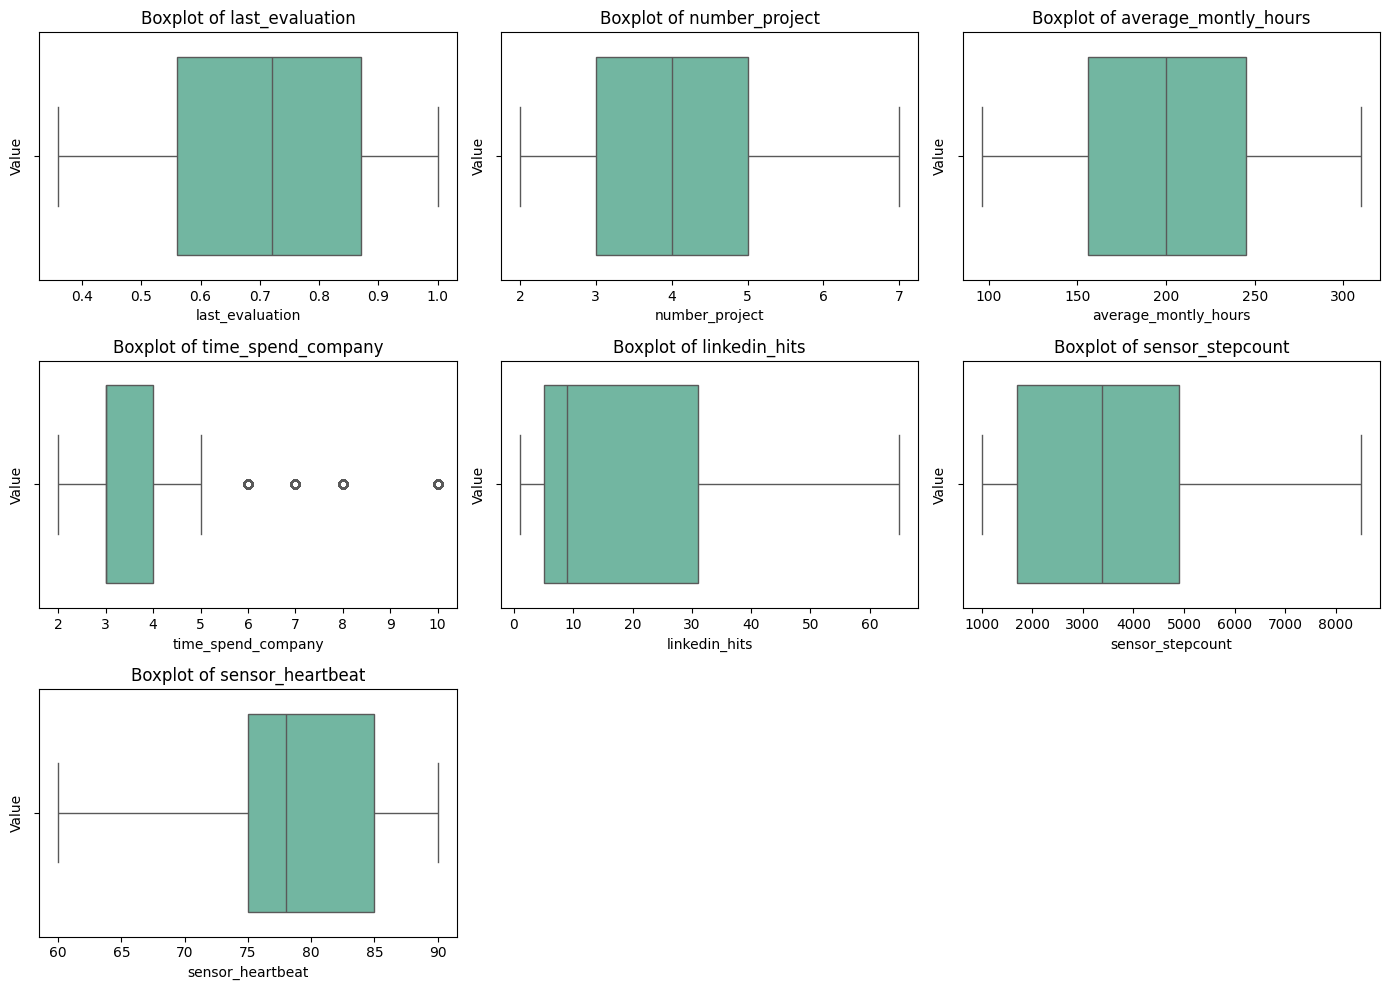

In [13]:
# detecting outliers with numerical columns only

numerical_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'time_spend_company', 'linkedin_hits', 'sensor_stepcount',
                     'sensor_heartbeat']

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=data[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [14]:
# time_spend_company is the only numeric variable with outliers therefore we will use the Robust Scaler.

rb_scaler = RobustScaler()
data['time_spend_company'] = rb_scaler.fit_transform(data[['time_spend_company']])

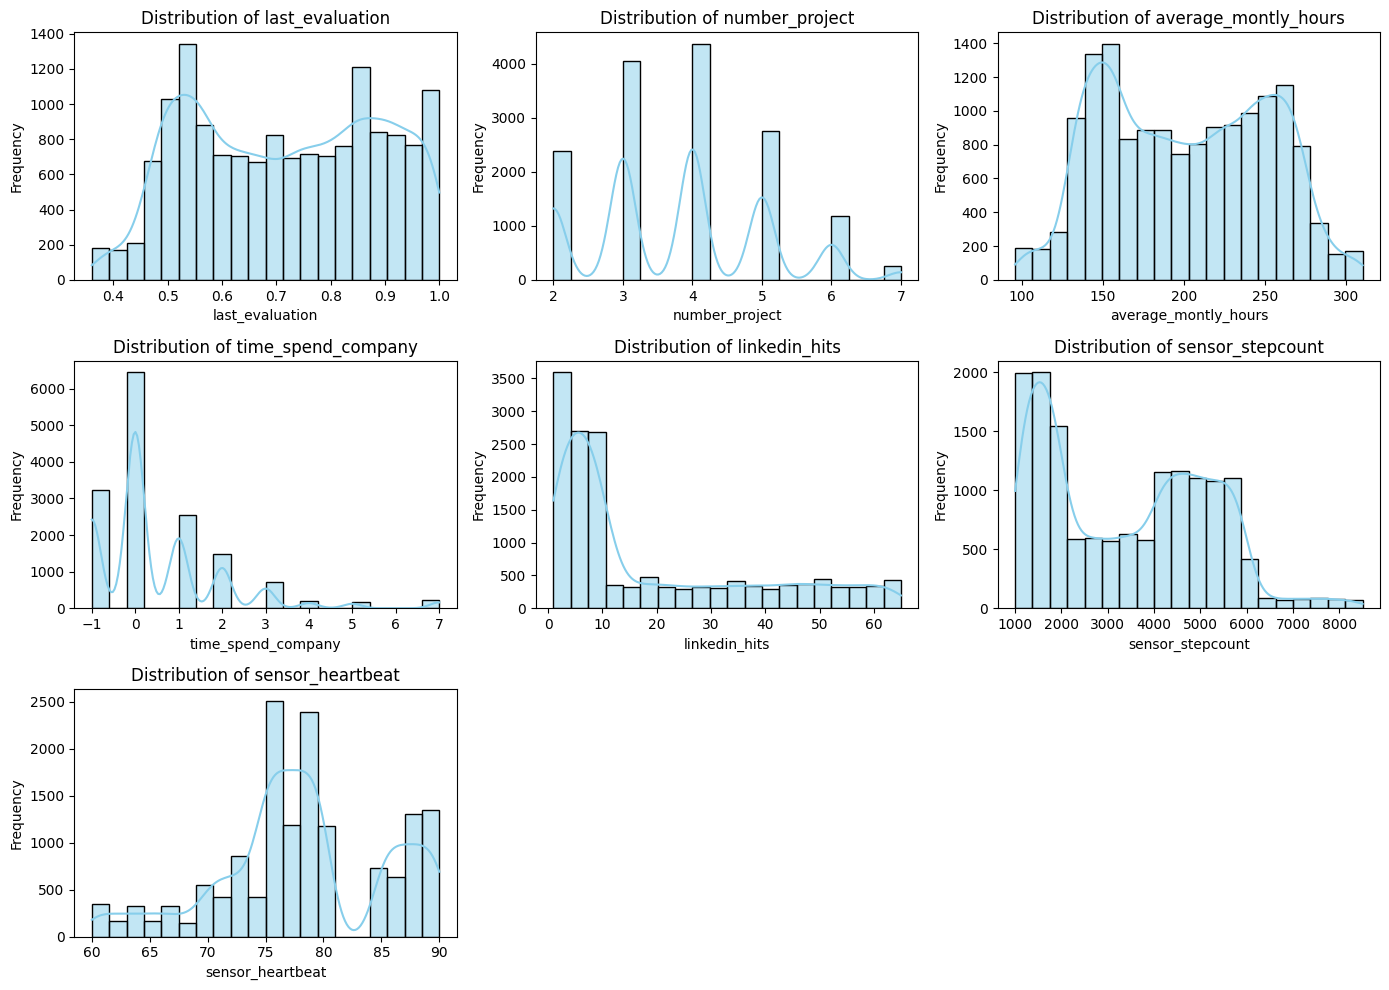

In [15]:
# plot the distributions of the numerical features to determine which scalers to use
# none of the plots seems to be normally distributed so the MinMaxScaling is chosen

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[column], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [16]:
# for all other numerical variables, use the minmaxscaler

minmaxscaler_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'linkedin_hits', 'sensor_stepcount', 'sensor_heartbeat']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data using MinMaxScaler
data[minmaxscaler_columns] = scaler.fit_transform(data[minmaxscaler_columns])

## Categorical Features ONLY Feature Engineering

In [17]:
# ordinal encoding for salary

ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(data[['salary']])
data['encoded_salary'] = ordinal_encoder.transform(data[['salary']]) # 1 = low, 2 = medium, 3 = high
data.drop(columns = ['salary'], inplace = True)

In [18]:
# OneHotEncoding for department, geo and role

ohe_columns = ['department', 'geo', 'role']

ohe = OneHotEncoder(sparse_output = False)

ohe_data = ohe.fit_transform(data[ohe_columns])

ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(ohe_columns))

encoded_data = pd.concat([data, ohe_df], axis=1)

encoded_data.drop(columns = ['department', 'geo', 'role'], inplace = True)

## Defining X (features) and Y (targets)

In [19]:
# define x and y variables

X = encoded_data.drop(columns = 'left_company')
y = encoded_data['left_company']

## Feature correlation

<Axes: >

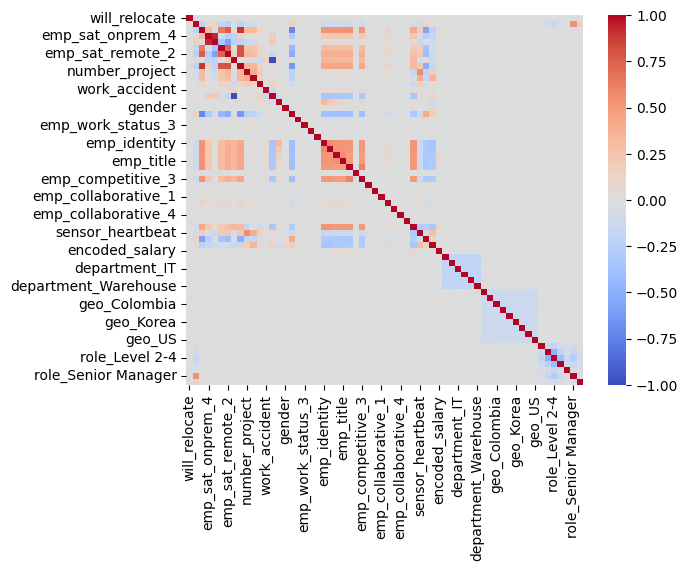

In [20]:
# Correlation Matrix
sns.heatmap(encoded_data.corr(), cmap='coolwarm')

In [21]:
# Calculate the correlation matrix
corr_matrix = X.corr()

In [22]:
# Create an empty list to store correlation pairs
correlation_pairs = []

# Iterate through the correlation matrix
for i, col in enumerate(corr_matrix.columns):
    for j, index in enumerate(corr_matrix.index):
        if i < j:  # Only store pairs once to avoid duplicates and self-correlation
            correlation_pairs.append([index, col, corr_matrix.iloc[j, i]])

In [23]:
# Convert the list to a DataFrame
corr_df = pd.DataFrame(correlation_pairs, columns=['feature_1', 'feature_2', 'correlation'])

# sort by correlation
corr_df.sort_values(by="correlation",ascending=False, inplace=True) 
corr_df

# Remove self correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] 

# Select highly correlated features >= 0.7 or <= -0.7
correlated_features = corr_df[(corr_df['correlation'] >= 0.7) | (corr_df['correlation'] <= -0.7)]
correlated_features

feature_1         feature_2  correlation
177  emp_sat_onprem_5  emp_sat_onprem_4     0.930062
124   last_evaluation    percent_remote     0.897223
346   last_evaluation  emp_sat_remote_2     0.805922
292   last_evaluation  emp_sat_remote_1     0.796292
122  emp_sat_remote_2    percent_remote     0.762327
290  emp_sat_remote_2  emp_sat_remote_1     0.735748
131     linkedin_hits    percent_remote    -0.713644

In [24]:
# remove highly correlated features >= 0.7 or <= -0.7

correlated_features = corr_df[(corr_df['correlation'] >= 0.7) | (corr_df['correlation'] <= -0.7)]

X.drop(columns = ['emp_sat_onprem_4', 'percent_remote', 'emp_sat_remote_2', 'emp_sat_remote_1', 'emp_engagement_1'], inplace = True)

## Random Forrest

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
# Evaluate the model
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2286
           1       0.99      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion Matrix:
[[2280    6]
 [  16  698]]


## Evaluating the model

In [28]:
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2286
           1       0.99      0.98      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion Matrix:
[[2280    6]
 [  16  698]]


## Feature importance

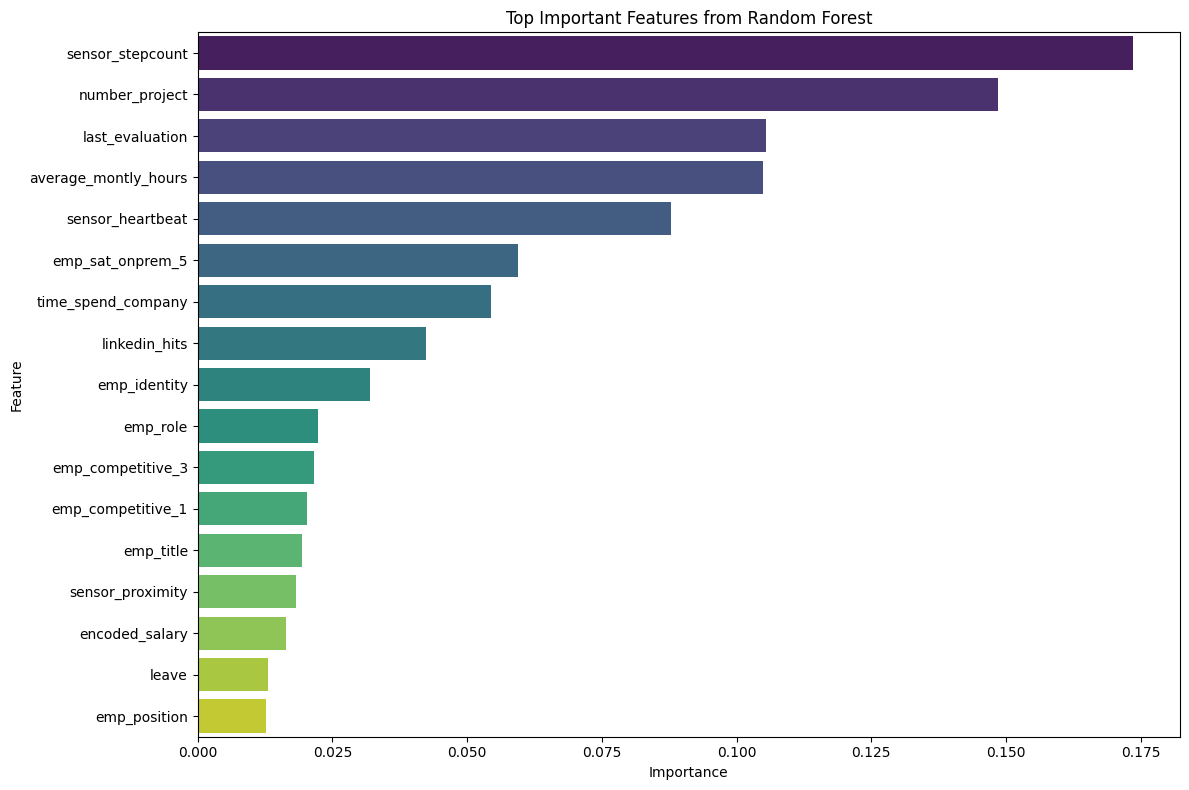

In [29]:
feature_names = X.columns.tolist()

rf_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
})

# Filter features with importance greater than 0.01
rf_feature_importance = rf_feature_importance[rf_feature_importance['Importance'] > 0.01]

# Plotting feature importance using Seaborn for better visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance.sort_values(by='Importance', ascending=False), palette='viridis')
plt.title('Top Important Features from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Logistic regression

In [30]:
# Create a train set and a test set, train = 10499, test = 4500
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=10)

In [31]:
# instantiate the model

log_reg = LogisticRegression(class_weight='balanced')

# fit the model to train set
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [32]:
# cross validation

cv_results = cross_validate(log_reg,
                            X_train,
                            y_train,
                            cv=5,
                            scoring=['accuracy'])

score = cv_results['test_accuracy'].mean()
print(f"Cross-validation mean accuracy results = {score}")

Cross-validation mean accuracy results = 0.8506539622042242


In [33]:
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))

Accuracy: 0.8417777777777777
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      3449
           1       0.61      0.87      0.72      1051

    accuracy                           0.84      4500
   macro avg       0.78      0.85      0.80      4500
weighted avg       0.87      0.84      0.85      4500



## Unsupervised learning

## K-means 

In [34]:
from sklearn.cluster import KMeans

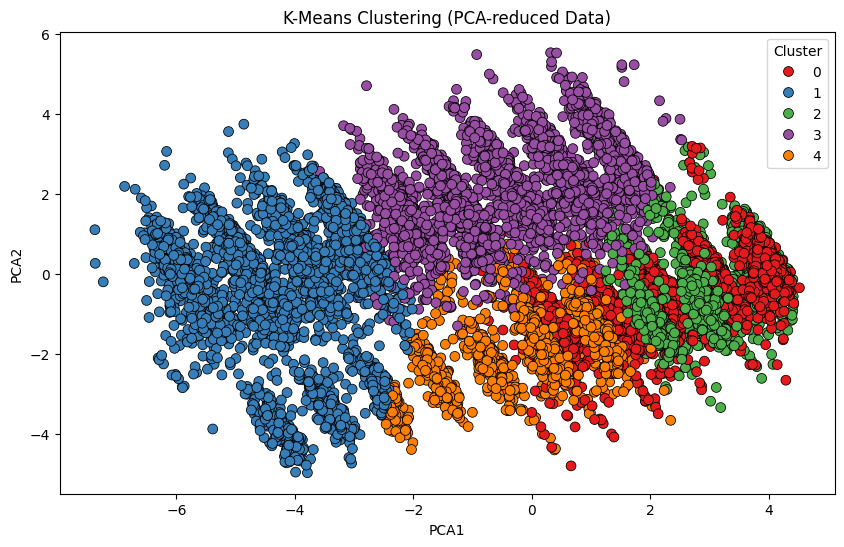

In [35]:
kmeans = KMeans(n_clusters=5, random_state=42)
data['Cluster'] = kmeans.fit_predict(X)

# Print cluster centers
# print("Cluster Centers:\n", kmeans.cluster_centers_)

# Add the cluster labels to the original data
data['Cluster'] = kmeans.labels_

from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = data['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

In [36]:
data.head()

department     geo             role  will_relocate  critical  \
0       Operations      US               VP              0       1.0   
1            Sales      UK  Senior Director              0       0.0   
2          Finance  France  Senior Director              0       0.0   
3  Human Resources   China  Senior Director              0       0.0   
4               IT   Korea         Director              0       0.0   

   percent_remote  emp_sat_onprem_4  emp_sat_onprem_5  emp_sat_remote_1  \
0             0.4               3.0               5.0                 2   
1             0.4               3.0               5.0                 2   
2             0.4               3.0               5.0                 2   
3             0.4               3.0               5.0                 2   
4             0.4               3.0               5.0                 2   

   emp_sat_remote_2  emp_engagement_1  last_evaluation  number_project  \
0                 3                 5              0.0             0.2   
1                 3                 5              0.0             0.6   
2                 3                 5              0.0             0.0   
3                 3                 5              0.0             0.4   
4                 3                 5              0.0             0.8   

   average_montly_hours  time_spend_company  work_accident  left_company  \
0              0.336449                 0.0              1             0   
1              0.294393                -1.0              0             0   
2              0.869159                 0.0              0             0   
3              0.850467                 1.0              1             0   
4              0.747664                 2.0              0             0   

   promotion_last_5years  gender  linkedin_hits  emp_work_status2  \
0                      0       0       0.062500                 4   
1                      0       1       0.890625                 3   
2                      0       1       0.640625                 2   
3                      0       0       0.562500                 3   
4                      0       1       0.078125                 4   

   emp_work_status_3  emp_work_status_4  emp_work_status_5  emp_identity  \
0                  3                  1                  1             1   
1                  3                  4                  3             2   
2                  4                  1                  3             1   
3                  1                  4                  5             2   
4                  5                  4                  5             1   

   emp_role  emp_position  emp_title  emp_competitive_1  emp_competitive_2  \
0         1             2          1                  2                  4   
1         1             2          1                  2                  2   
2         1             2          2                  1                  5   
3         1             2          1                  1                  1   
4         1             2          1                  1                  4   

   emp_competitive_3  emp_competitive_4  emp_competitive_5  \
0                  2                  2                  2   
1                  1                  4                  1   
2                  1                  2                  5   
3                  2                  5                  1   
4                  1                  5                  3   

   emp_collaborative_1  emp_collaborative_2  emp_collaborative_3  \
0                    2                    2                    2   
1                    3                    2                    5   
2                    2                    2                    4   
3                    1                    2                    4   
4                    5                    1                    2   

   emp_collaborative_4  emp_collaborative_5  sensor_stepcount  \
0                    1            

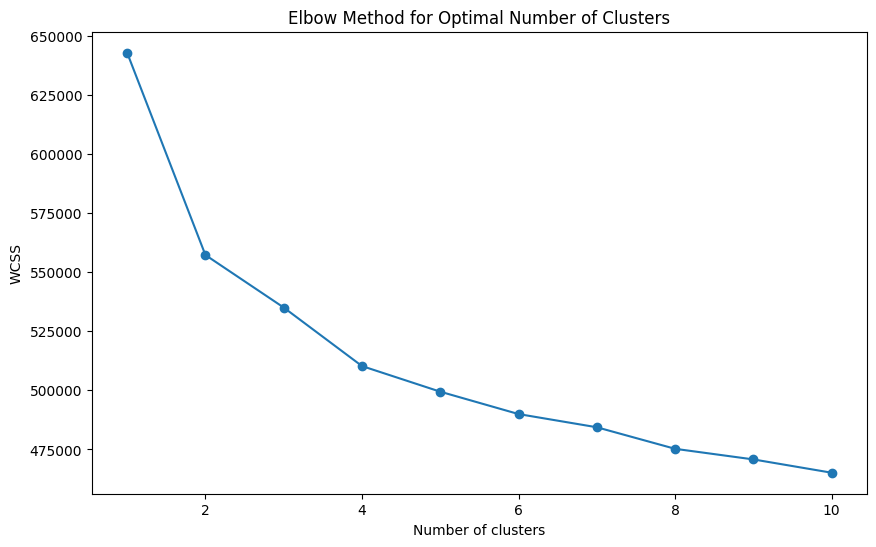

In [37]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to determine the optimal number of clusters
wcss = []  # within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [38]:
# Print cluster centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
print("Cluster Centers:\n", cluster_centers)

Cluster Centers:
    will_relocate      critical  emp_sat_onprem_5  last_evaluation  \
0       0.501056  5.279831e-04          1.000000         0.464114   
1       0.493953 -8.326673e-17          4.000000         0.837922   
2       0.531191  2.646503e-02          3.790170         0.577475   
3       0.496885 -8.326673e-17          4.000000         0.763994   
4       0.482051  6.410256e-02          4.837821         0.342829   
5       0.521969  1.058761e-03          4.001588         0.756626   
6       0.505858  7.236389e-02          4.825637         0.349802   
7       0.510549  7.876231e-02          4.824191         0.350090   
8       0.480625  9.721278e-02          4.849082         0.338237   
9       0.490460  1.683502e-03          4.014590         0.741767   

   number_project  average_montly_hours  time_spend_company  work_accident  \
0        0.358078              0.472639            0.108237       0.165787   
1        0.640930              0.737279            1.625116       

In [39]:
# Analyze the number of points in each cluster
cluster_distribution = data['Cluster'].value_counts().sort_index()
print("Cluster Distribution:\n", cluster_distribution)

Cluster Distribution:
 Cluster
0    1974
1    3304
2    3421
3    3301
4    2999
Name: count, dtype: int64


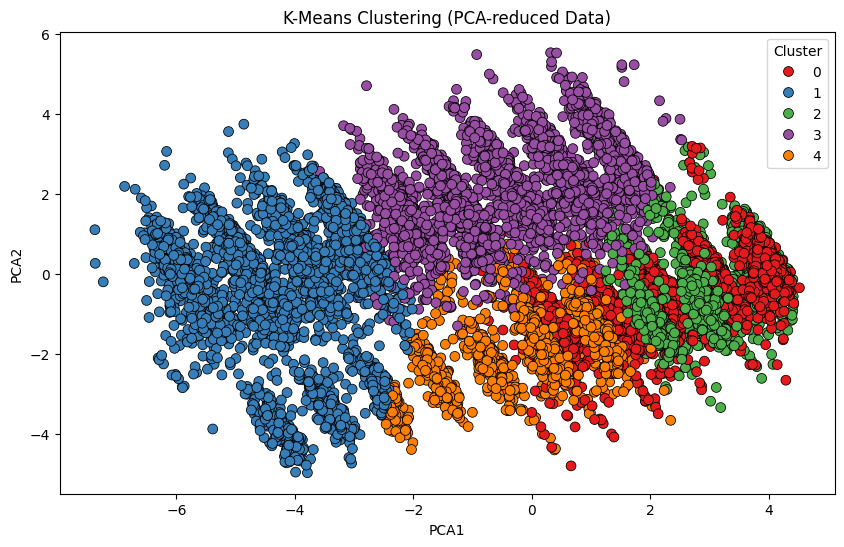

In [40]:
# Reduce dimensions to 2D for visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = data['Cluster']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

Comparison Table:
 Cluster              0         1         2         3         4
left_company                                                  
0             0.168533  0.239412  0.181047  0.286052  0.124956
1             0.013442  0.159059  0.378605  0.008961  0.439933


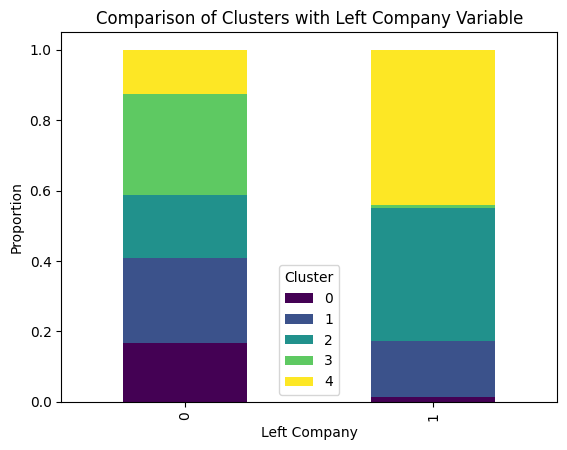

In [41]:
# If you have external variables, compare them with clusters
# For example, comparing clusters with the original 'left_company' variable

comparison_df = data[['left_company', 'Cluster']]
comparison_table = pd.crosstab(comparison_df['left_company'], comparison_df['Cluster'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Left Company')
plt.ylabel('Proportion')
plt.legend(title='Cluster')
plt.show()

## Using feature selection

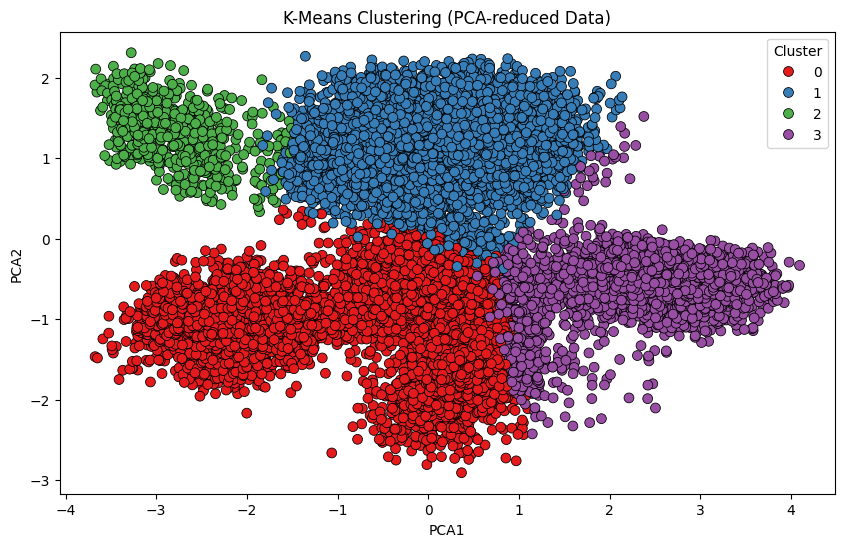

In [42]:
selected_features = ['last_evaluation', 'number_project', 'average_montly_hours', 'sensor_stepcount','sensor_heartbeat'] 
X_selected = data[selected_features]

# Standardize the selected features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Apply K-Means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clusters using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = data['Cluster']

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

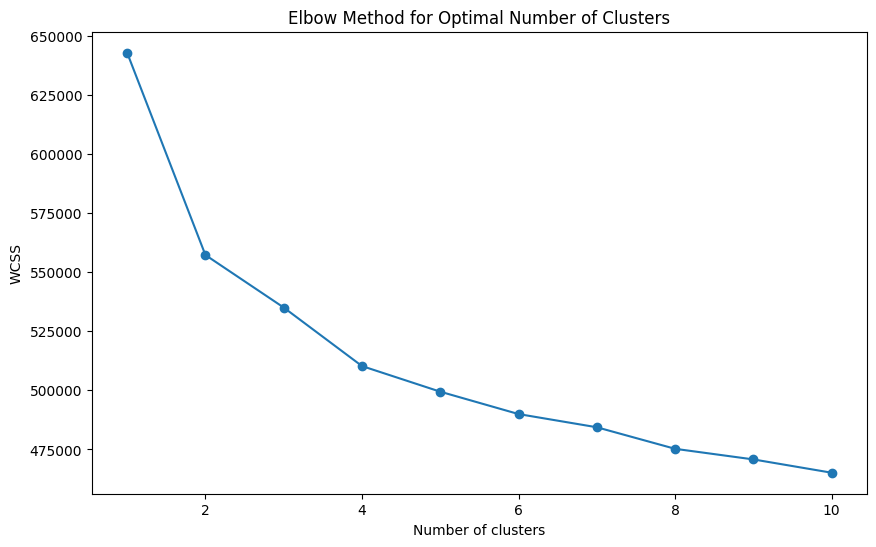

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to determine the optimal number of clusters
wcss = []  # within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Comparison Table:
 left_company         0         1
Cluster                         
0             0.818980  0.181020
1             0.999337  0.000663
2             0.120915  0.879085
3             0.164076  0.835924


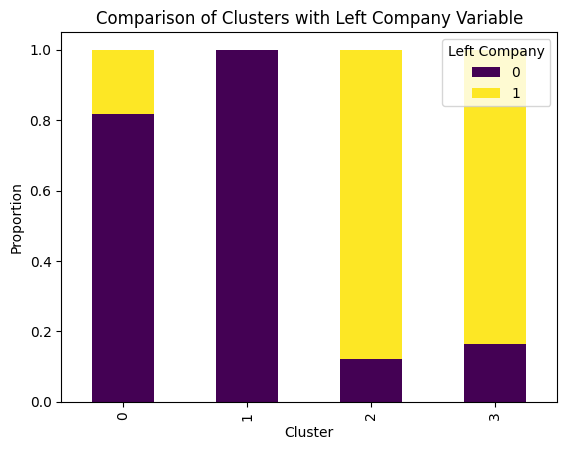

In [44]:
# Compare clusters with the 'left_company' variable
comparison_df = data[['Cluster', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()